# Predictive Maintenance

## Dataset 4 - Binary Classification using LSTM

- Label 0 = RUL of Machine is greater than 30 cycles
- Label 1 = RUL of Machine is less than or equal to 30 cycles

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

## Read Train and Test Data

In [3]:
train_df = pd.read_csv('data/train_04.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
test_df = pd.read_csv('data/test_04.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
truth_df = pd.read_csv('data/truth_04.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [6]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


## Generate Labels for Train Data

In [7]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [8]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,9.3335,0.02,330,2212,100.00,10.62,6.3670,320,0,0
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,9.1913,0.02,361,2324,100.00,24.37,14.6552,319,0,0
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,9.4007,0.02,329,2212,100.00,10.48,6.4213,318,0,0
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,9.3369,0.02,328,2212,100.00,10.54,6.4176,317,0,0
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,10.8366,0.02,305,1915,84.93,14.03,8.6754,316,0,0


## Normalize Train and Test Data

In [9]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.0,0.288660,0.627907,1.0,0.015473,0.015881,320,0,0,0.000000
1,1,2,0.476147,0.831591,1.0,0.626985,0.647971,0.634407,0.511781,0.507937,...,0.0,0.608247,0.864693,1.0,0.477968,0.481487,319,0,0,0.001845
2,1,3,0.999900,0.998694,1.0,0.000000,0.123646,0.271245,0.222481,0.000000,...,0.0,0.278351,0.627907,1.0,0.010764,0.018932,318,0,0,0.003690
3,1,4,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.0,0.268041,0.627907,1.0,0.012782,0.018724,317,0,0,0.005535
4,1,5,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.0,0.030928,0.000000,0.0,0.130172,0.145560,316,0,0,0.007380


In [10]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.476271,0.831354,1.0,0.626985,0.653479,0.643669,0.488507,0.507937,...,0.992533,0.488614,0.362278,0.0,0.618557,0.864693,1.0,0.475950,0.484043,0.000000
1,1,2,0.595087,0.736342,0.0,0.238089,0.006793,0.036454,0.016957,0.293184,...,0.001433,0.042513,0.929738,0.0,0.041237,0.000000,0.0,0.141271,0.139909,0.001845
2,1,3,0.999810,1.000000,1.0,0.000000,0.126216,0.263171,0.195653,0.000000,...,0.993001,0.541876,0.422161,0.0,0.268041,0.627907,1.0,0.007736,0.019786,0.003690
3,1,4,0.999893,0.997862,1.0,0.000000,0.125849,0.262010,0.198967,0.000000,...,0.992863,0.560536,0.409500,0.0,0.268041,0.627907,1.0,0.013454,0.008561,0.005535
4,1,5,0.833363,0.997625,1.0,0.060269,0.180099,0.298031,0.224282,0.146592,...,0.992781,0.509895,0.389988,0.0,0.319588,0.651163,1.0,0.157753,0.160009,0.007380


## Generate Labels for Test Data

In [11]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [12]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.476271,0.831354,1.0,0.626985,0.653479,0.643669,0.488507,0.507937,...,0.488614,0.362278,0.0,0.618557,0.864693,1.0,0.475950,0.484043,0.000000,251
1,1,2,0.595087,0.736342,0.0,0.238089,0.006793,0.036454,0.016957,0.293184,...,0.042513,0.929738,0.0,0.041237,0.000000,0.0,0.141271,0.139909,0.001845,250
2,1,3,0.999810,1.000000,1.0,0.000000,0.126216,0.263171,0.195653,0.000000,...,0.541876,0.422161,0.0,0.268041,0.627907,1.0,0.007736,0.019786,0.003690,249
3,1,4,0.999893,0.997862,1.0,0.000000,0.125849,0.262010,0.198967,0.000000,...,0.560536,0.409500,0.0,0.268041,0.627907,1.0,0.013454,0.008561,0.005535,248
4,1,5,0.833363,0.997625,1.0,0.060269,0.180099,0.298031,0.224282,0.146592,...,0.509895,0.389988,0.0,0.319588,0.651163,1.0,0.157753,0.160009,0.007380,247


In [13]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.476271,0.831354,1.0,0.626985,0.653479,0.643669,0.488507,0.507937,...,0.0,0.618557,0.864693,1.0,0.475950,0.484043,0.000000,251,0,0
1,1,2,0.595087,0.736342,0.0,0.238089,0.006793,0.036454,0.016957,0.293184,...,0.0,0.041237,0.000000,0.0,0.141271,0.139909,0.001845,250,0,0
2,1,3,0.999810,1.000000,1.0,0.000000,0.126216,0.263171,0.195653,0.000000,...,0.0,0.268041,0.627907,1.0,0.007736,0.019786,0.003690,249,0,0
3,1,4,0.999893,0.997862,1.0,0.000000,0.125849,0.262010,0.198967,0.000000,...,0.0,0.268041,0.627907,1.0,0.013454,0.008561,0.005535,248,0,0
4,1,5,0.833363,0.997625,1.0,0.060269,0.180099,0.298031,0.224282,0.146592,...,0.0,0.319588,0.651163,1.0,0.157753,0.160009,0.007380,247,0,0


## Visualizing Test Set

In [14]:
# window size
sequence_length = 50

In [15]:
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

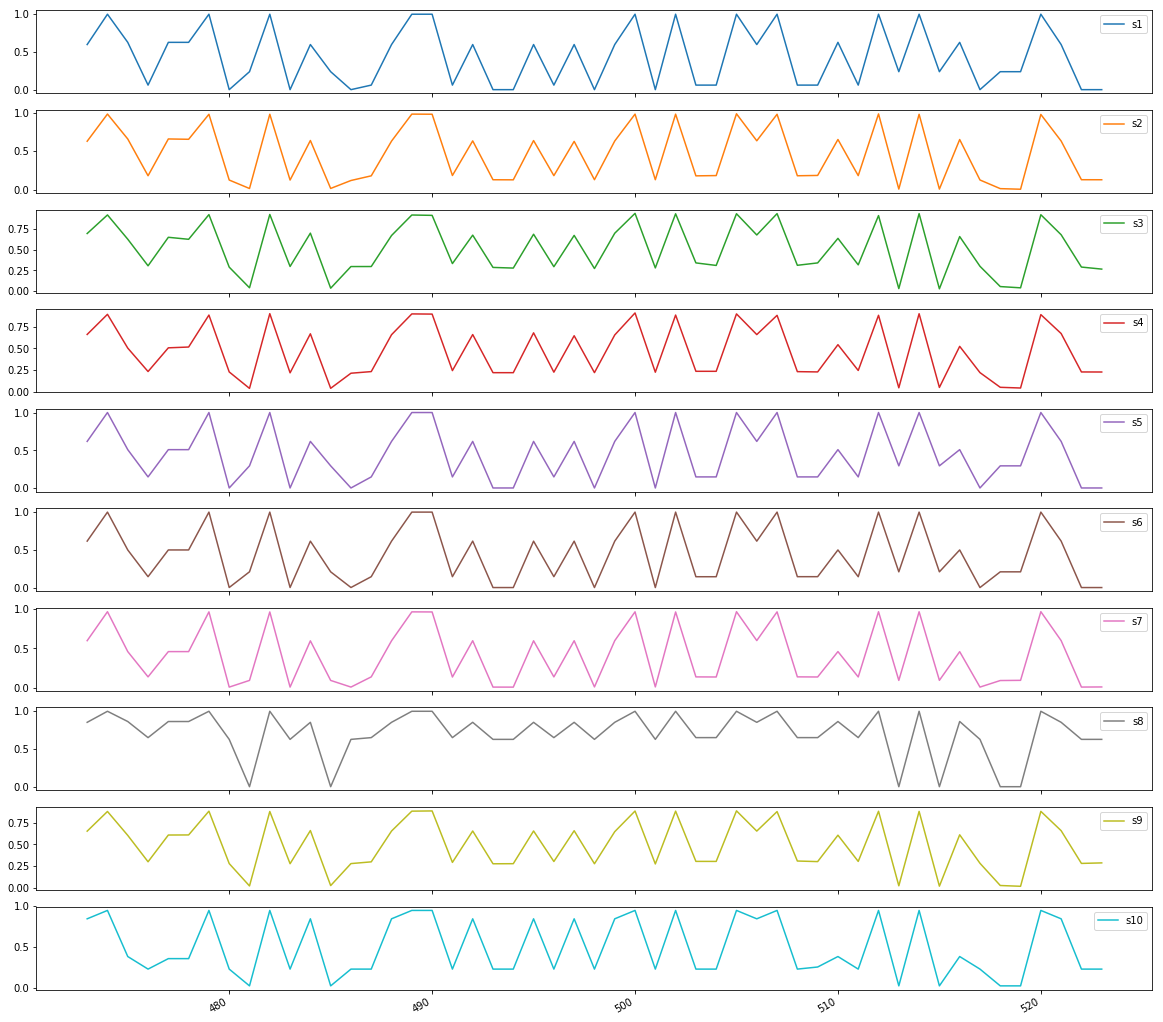

In [16]:
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

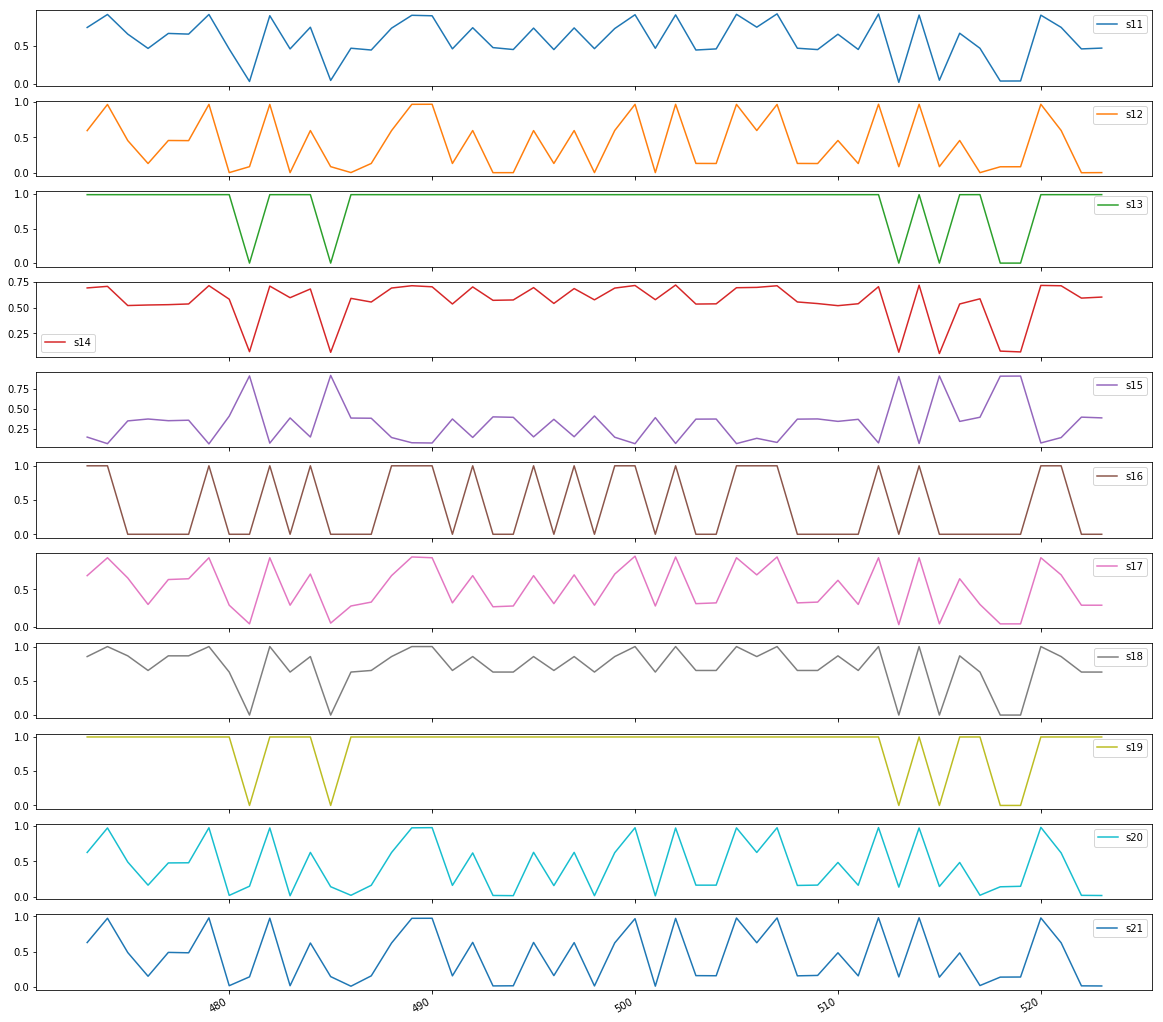

In [17]:
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

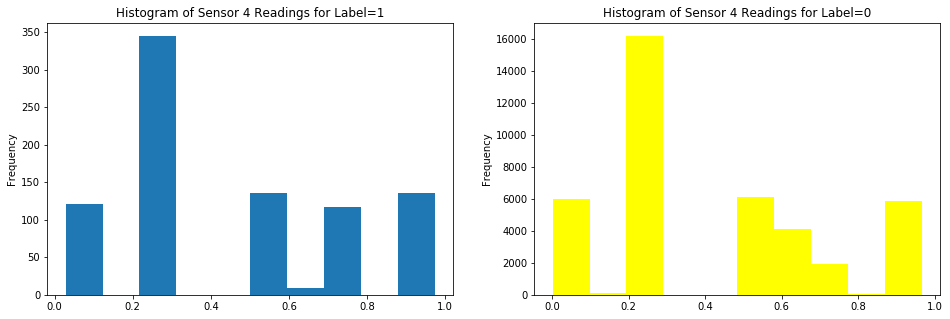

In [18]:
p = test_df[test_df['label1']==1]
n = test_df[test_df['label1']==0]

fig = plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
ax3 = p['s4'].plot(kind='hist')
plt.title('Histogram of Sensor 4 Readings for Label=1')
plt.subplot(1, 2, 2)
ax4 = n['s4'].plot(sharex= ax3, kind='hist', facecolor='yellow')
plt.title('Histogram of Sensor 4 Readings for Label=0')
plt.show()

## Train and Test Sequences

In [19]:
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [20]:
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [21]:
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [22]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(48799, 50, 25)

In [23]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [24]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(48799, 1)

## Model

In [25]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 130,901
Trainable params: 130,901
Non-trainable params: 0
_________________________________________________________________
None


## Training the Model

In [27]:
%%time
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 46359 samples, validate on 2440 samples
Epoch 1/10
46359/46359 [==============================] - 249s 5ms/step - loss: 0.3152 - acc: 0.8716 - val_loss: 0.2598 - val_acc: 0.8996
Epoch 2/10
46359/46359 [==============================] - 145s 3ms/step - loss: 0.2254 - acc: 0.9060 - val_loss: 0.2206 - val_acc: 0.9213
Epoch 3/10
46359/46359 [==============================] - 126s 3ms/step - loss: 0.1985 - acc: 0.9196 - val_loss: 0.2230 - val_acc: 0.9242
CPU times: user 18min 50s, sys: 1min 56s, total: 20min 46s
Wall time: 8min 42s


## Results on Train Set

In [28]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

48799/48799 [==============================] - 41s 838us/step
Accurracy: 0.9260230752082557


In [29]:
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print (cm)

48799/48799 [==============================] - 40s 826us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[39311  1769]
 [ 1841  5878]]


In [30]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.7686674512880868 
 recall =  0.7614976033164917


## Results on Test Set

In [31]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(228, 50, 25)

In [32]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]


In [33]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(228, 1)

In [34]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(228, 50, 25)
(228, 1)


In [35]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

Accurracy: 0.9035087719298246


In [36]:
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print (cm)

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[168   7]
 [ 15  38]]


In [37]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.8444444444444444 
 Recall:  0.7169811320754716 
 F1-score: 0.7755102040816326


## Summary of Results on Test Set

In [38]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.903509,0.844444,0.716981,0.77551
